<a href="https://colab.research.google.com/github/marleenkj/so2_prediction/blob/main/prediction_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for 2017-2019

https://colab.research.google.com/drive/1RQQGulY3tuhsRglYVcDU-ovfmLSVWry3?usp=sharing 

## Importing

### Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import math
from numpy.ma.core import empty

import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score
import tensorflow as tf
from tensorflow import keras

In [ ]:
import scipy

### Importing data

#### SO2 Ground Data

In [ ]:
ground_data = pd.read_csv('so2_2017.csv') # ground data of 2017

#### SO2 Satellites

In [ ]:
so2_sat = pd.read_csv('2017-SO2.csv') # satellites measures

#### O3 Satellites

In [ ]:
#o3_sat = pd.read_csv('o3_2017.csv') # ground data of 2017

#### NO2 Satellites

In [ ]:
#no2_sat = pd.read_csv('no2_2017.csv') # ground data of 2017

#### PM10 Satellites

In [ ]:
pm10_sat = pd.read_csv('2017-PM10.csv') # satellites of 2017

### Function for bilinear interpolation

In [ ]:
def bilinear_interpolation_rect(latitude, longitude, satellites):
  x = latitude
  y = longitude

  # rounding to the nearest .75
  latitude_low = math.floor(latitude*4/3)/(4/3) #rounds down 
  x1 = latitude_low
  latitude_high = math.ceil(latitude*4/3)/(4/3) #rounds up
  x2 = latitude_high
  longitude_low = math.floor(longitude*4/3)/(4/3) #rounds down 
  y1 = longitude_low
  longitude_high = math.ceil(longitude*4/3)/(4/3) #rounds up
  y2 = longitude_high

  # getting the so2 values from the satellites measures  
  #if ((satellites['latitude'] == first_point[0]) & (satellites['longitude'] == first_point[1])):
  df_first = satellites[(satellites['latitude'] == latitude_low) & (satellites['longitude'] == longitude_low)] #lowlow
  df_second = satellites[(satellites['latitude'] == latitude_low) & (satellites['longitude'] == longitude_high)] #lowhigh
  df_third = satellites[(satellites['latitude'] == latitude_high) & (satellites['longitude'] == longitude_low)] #highlow
  df_fourth = satellites[(satellites['latitude'] == latitude_high) & (satellites['longitude'] == longitude_high)] #highhigh

  if df_first.empty:
    value_first = 0
  else:
    value_first = df_first.t2m.item() #q11
  
  if df_second.empty:
    value_first = 0
  else:
    value_second = df_second.t2m.item() #q12

  if df_third.empty:
    value_first = 0
  else:
    value_third = df_third.t2m.item() #q21

  if df_fourth.empty:
    value_first = 0
  else:
    value_fourth = df_fourth.t2m.item() #q22

  q11 = value_first
  q12 = value_second
  q21 = value_third
  q22 = value_fourth

  if q11 == 0 or q21 == 0 or q12 == 0 or q22 == 0:
    final = np.nan
  else:
    final = (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

  return final

## Exploratory Data Analysis & Cleaning

### Satellites Data

In [ ]:
so2_sat.shape

(1388160, 4)

In [ ]:
so2_sat.describe()

latitude     longitude           t2m
count  1.388160e+06  1.388160e+06  1.388160e+06
mean   0.000000e+00 -3.750000e-01  7.809446e-07
std    5.217760e+01  1.039229e+02  1.801240e-06
min   -9.000000e+01 -1.800000e+02  4.260396e-08
25%   -4.500000e+01 -9.018750e+01  2.445306e-07
50%    0.000000e+00 -3.750000e-01  3.937808e-07
75%    4.500000e+01  8.943750e+01  7.625165e-07
max    9.000000e+01  1.792500e+02  1.918232e-04

#### From monthly mean to yearly mean

In [ ]:
def to_yearly_mean(data):

  # Correcting datatype
  data['date'] = pd.to_datetime(data['time'])
  data.drop(['time'],axis = 1)

  # Creating a Year column
  data['Year']= pd.DatetimeIndex(data['date']).year

  # Grouping by year; aggregating by mean
  data_yearly = data.groupby(['Year','latitude','longitude'])['t2m'].agg('mean').reset_index()
  
  return data_yearly

In [ ]:
so2_sat[(so2_sat['latitude']==90) & (so2_sat["longitude"]==90)]

time  latitude  longitude           t2m
360      2017-01-01T00:00:00      90.0       90.0  1.470723e-06
116040   2017-02-01T00:00:00      90.0       90.0  9.000607e-07
231720   2017-03-01T00:00:00      90.0       90.0  2.972072e-07
347400   2017-04-01T00:00:00      90.0       90.0  2.240453e-07
463080   2017-05-01T00:00:00      90.0       90.0  1.216187e-07
578760   2017-06-01T00:00:00      90.0       90.0  1.655159e-07
694440   2017-07-01T00:00:00      90.0       90.0  1.274717e-07
810120   2017-08-01T00:00:00      90.0       90.0  1.508835e-07
925800   2017-09-01T00:00:00      90.0       90.0  1.157658e-07
1041480  2017-10-01T00:00:00      90.0       90.0  2.445306e-07
1157160  2017-11-01T00:00:00      90.0       90.0  4.318250e-07
1272840  2017-12-01T00:00:00      90.0       90.0  8.795754e-07

In [ ]:
# SO2 satellites data
so2_sat_yearly = to_yearly_mean(so2_sat)

In [ ]:
so2_sat_yearly[(so2_sat_yearly["Year"]==2017) & (so2_sat_yearly['latitude']==90) & (so2_sat_yearly["longitude"]==90)]

Year  latitude  longitude           t2m
115560  2017      90.0       90.0  4.274352e-07

In [ ]:
# PM10 satellites data
pm10_sat_yearly = to_yearly_mean(pm10_sat)
pm10_sat_yearly.shape

(115680, 4)

### Ground data


In [ ]:
ground_data.shape

(1821, 26)

In [ ]:
ground_data.head()

Country Air Quality Network         Air Quality Network Name  \
0  Germany           NET.DE_MV                   Thomas Draheim   
1   France          NET-FR074A             ATMO HAUTS DE FRANCE   
2  Germany           NET.DE_NW                   Jürgen Friesel   
3  Germany           NET.DE_RP                Margit von Döhren   
4  Hungary          NET-HU004A  "Hungarian Air Quality Network"   

  Air Quality Station EoI Code     Air Quality Station Name  \
0                      DEMV021           Rostock-Warnemünde   
1                      FR28022            St-Laurent-Blangy   
2                      DENW021              Bottrop-Welheim   
3                      DERP019  Kaiserslautern-Rathausplatz   
4                      HU0036A      "Budapest Pesthidegkut"   

               Sampling Point Id Air Pollutant Air Pollutant Description  \
0  SPO.DE_DEMV021_SO2_dataGroup1           SO2     Sulphur dioxide (air)   
1                  SPO-FR28022_1           SO2     Sulphur dioxide (air)   
2  SPO.DE_DENW021_SO2_dataGroup1           SO2     Sulphur dioxide (air)   
3  SPO.DE_DERP019_SO2_dataGroup1           SO2     Sulphur dioxide (air)   
4          SPO-HU0036A_00001_100           SO2     Sulphur dioxide (air)   

  Data Aggregation Process Id       Data Aggregation Process  ...  \
0                         P1Y  Annual mean / 1 calendar year  ...   
1                         P1Y  Annual mean / 1 calendar year  ...   
2                         P1Y  Annual mean / 1 calendar year  ...   
3                         P1Y  Annual mean / 1 calendar year  ...   
4                         P1Y  Annual mean / 1 calendar year  ...   

   Air Quality Station Area  Longitude Latitude  Altitude  \
0                     Urban    12.0800  54.1713       2.0   
1                  Suburban     2.8074  50.3089      90.0   
2                     Urban     6.9769  51.5260      30.0   
3                     Urban     7.7673  49.4460     232.0   
4                  Suburban    18.9600  47.5619     265.0   

                                                City  \
0  Rostock                                       ...   
1  Arras                                         ...   
2                                                NaN   
3  Kaiserslautern                                ...   
4  Budapest                                      ...   

                                           City Code City Population  \
0  DE043C1                                       ...        201195.0   
1  FR064C2                                       ...         91972.0   
2                                                NaN             NaN   
3  DE044C1                                       ...         95839.0   
4  HU001C1                                       ...       1728868.0   

                 Source Of Data Flow     Calculation Time  \
0  E1a/validated data AQ e-Reporting  12/02/2022 20:31:37   
1  E1a/validated data AQ e-Reporting  12/02/2022 20:31:37   
2  E1a/validated data AQ e-Reporting  12/02/2022 20:31:37   
3  E1a/validated data AQ e-Reporting  12/02/2022 20:31:37   
4  E1a/validated data AQ e-Reporting  12/02/2022 20:31:37   

   Link to raw data (only E1a/validated data from AQ e-Reporting)  
0  http://fme.discomap.eea.europa.eu/fmedatastrea...               
1  http://fme.discomap.eea.europa.eu/fmedatastrea...               
2  http://fme.discomap.eea.europa.eu/fmedatastrea...               
3  http://fme.discomap.eea.europa.eu/fmedatastrea...               
4  http://fme.discomap.eea.europa.eu/fmedatastrea...               

[5 rows x 26 columns]

In [ ]:
ground_data.describe()

Year  Air Pollution Level  Data Coverage  Verification    Longitude  \
count  1821.0          1801.000000    1821.000000   1821.000000  1821.000000   
mean   2017.0             5.085659      90.527029      1.021966    10.953722   
std       0.0             7.190668      17.938563      0.208502    13.678313   
min    2017.0            -0.639000       0.000000      1.000000   -61.041200   
25%    2017.0             1.819000      91.870000      1.000000     0.142700   
50%    2017.0             3.437000      95.610000      1.000000    12.061900   
75%    2017.0             6.415000      98.410000      1.000000    20.533500   
max    2017.0           166.923000     100.000000      3.000000    55.627900   

          Latitude     Altitude  City Population  
count  1821.000000  1821.000000     5.650000e+02  
mean     45.002195   235.617902     6.401382e+05  
std       8.088327   296.790298     1.071868e+06  
min     -21.334400     0.000000     0.000000e+00  
25%      40.726000    30.000000     1.149860e+05  
50%      44.533200   122.000000     2.145210e+05  
75%      49.971000   318.000000     6.020620e+05  
max      78.906700  1941.000000     8.171259e+06

In [ ]:
ground_data.isna().sum()

Country                                                              0
Air Quality Network                                                  0
Air Quality Network Name                                             0
Air Quality Station EoI Code                                         0
Air Quality Station Name                                             0
Sampling Point Id                                                    0
Air Pollutant                                                        0
Air Pollutant Description                                            0
Data Aggregation Process Id                                          0
Data Aggregation Process                                             0
Year                                                                 0
Air Pollution Level                                                 20
Unit Of Air Pollution Level                                          0
Data Coverage                                                        0
Verifi

## Data Preprocessing of Final Dataset

### Creating Final Dataset

In [ ]:
# Selecting the columns we need and storing it in a new dataframe
df_ground = ground_data[['Longitude','Latitude','Altitude','Air Pollution Level']]

In [ ]:
df_ground.shape

(1821, 4)

In [ ]:
df_ground.head(2)

Longitude  Latitude  Altitude  Air Pollution Level
0    12.0800   54.1713       2.0                1.099
1     2.8074   50.3089      90.0                0.200

In [ ]:
# Calculating So2
df = df_ground
df['so2_bilinear'] = np.nan
for i in range(len(np.array(df["Latitude"]))):
  df['so2_bilinear'][i] = bilinear_interpolation_rect(df['Latitude'][i], df['Longitude'][i], so2_sat_yearly)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude            1821 non-null   float64
 1   Latitude             1821 non-null   float64
 2   Altitude             1821 non-null   float64
 3   Air Pollution Level  1801 non-null   float64
 4   so2_bilinear         1820 non-null   float64
dtypes: float64(5)
memory usage: 71.3 KB


In [ ]:
# Organizing columns
df.columns = ['longitude', 'latitude', 'altitude', 'so2_target', 'so2']
df = df.reindex(columns=['longitude', 'latitude', 'altitude', 'so2', 'so2_target'])

In [ ]:
# Calculating PM10
df['pm10'] = np.nan
for i in range(len(np.array(df["latitude"]))):
  df['pm10'][i] = bilinear_interpolation_rect(df['latitude'][i], df['longitude'][i], pm10_sat_yearly)

df: uncleaned df

### Removing missing data & correcting data types

In [ ]:
# Missing data
df.isna().sum()

longitude      0
latitude       0
altitude       0
so2            1
so2_target    20
pm10           1
dtype: int64

In [ ]:
df_clean = df.dropna(how = 'any')
df_clean.reset_index(drop = True, inplace = True)

In [ ]:
df_clean.isna().sum()

longitude     0
latitude      0
altitude      0
so2           0
so2_target    0
pm10          0
dtype: int64

In [ ]:
df_clean.shape

(1800, 6)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longitude   1800 non-null   float64
 1   latitude    1800 non-null   float64
 2   altitude    1800 non-null   float64
 3   so2         1800 non-null   float64
 4   so2_target  1800 non-null   float64
 5   pm10        1800 non-null   float64
dtypes: float64(6)
memory usage: 84.5 KB


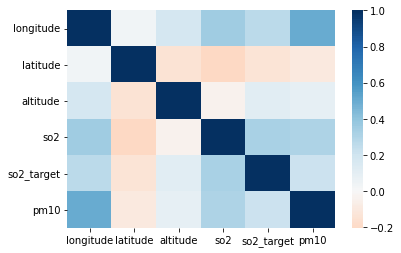

In [ ]:
# Heatmap for correlation between features
sns.heatmap(df.corr(), cmap='RdBu',center=0)
plt.show()

### Scaling & Splitting

In [ ]:
seed = 42

In [ ]:
def scaling_and_splitting (df):
    # Seperating target variable and the features
    target = df['so2_target']
    features = df.drop('so2_target',axis=1)

    scaler = preprocessing.MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Splitting in training and test set
    validation_size = 0.2
    seed = 42
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=validation_size, random_state=seed) 

    return X_train, X_test, y_train, y_test

In [ ]:
df_clean.head()

longitude  latitude  altitude           so2  so2_target          pm10
0    12.0800   54.1713       2.0  8.879602e-07       1.099  1.360516e-08
1     2.8074   50.3089      90.0  1.016114e-06       0.200  1.720592e-08
2     6.9769   51.5260      30.0  1.060388e-06      10.291  1.529519e-08
3     7.7673   49.4460     232.0  8.151013e-07       1.433  1.519075e-08
4    18.9600   47.5619     265.0  2.740181e-06       3.772  1.869390e-08

In [ ]:
df_basic = df_clean[['longitude','latitude','altitude','so2','so2_target']]

In [ ]:
df_adv = df_clean

Available dataset:


*   df_basic #dataset without missing values and without new features 
*   df_adv #dataset without missing values and with new features 



## Feature importance

In [ ]:
results_features = pd.DataFrame()
results_features = pd.DataFrame(columns=["dataset","relative_error","mean_absolute_error", "mean_squared_error", "median_absolute_error", "explained_variance_score", "r2_score"])

In [ ]:
def relative_error(y,pred):
  rel = (y-pred)/y
  rel_2 = rel**2
  rel_2_mean = np.mean(rel_2)
  rel_overall = np.sqrt(rel_2_mean)

  return rel_overall

### 1. One feature: SO2 from satellites (Baseline)

In [ ]:
df_basic.head(2)

longitude  latitude  altitude           so2  so2_target
0    12.0800   54.1713       2.0  8.879602e-07       1.099
1     2.8074   50.3089      90.0  1.016114e-06       0.200

In [ ]:
df1=df_basic.drop(["longitude","latitude","altitude"],axis=1)

In [ ]:
features = df1.drop('so2_target',axis=1)

In [ ]:
df1.head()

so2  so2_target
0  8.879602e-07       1.099
1  1.016114e-06       0.200
2  1.060388e-06      10.291
3  8.151013e-07       1.433
4  2.740181e-06       3.772

In [ ]:
X_train, X_test, y_train, y_test = scaling_and_splitting(df1)

In [ ]:
model = RandomForestRegressor(random_state = seed)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
feat_importances = pd.Series(
        model.feature_importances_,
        index=features.columns).sort_values(
        ascending=False)
feat_importances

so2    1.0
dtype: float64

In [ ]:
base_results = pd.DataFrame({"dataset": "One feature: SO2 from satellites (Baseline)",
                             "relative_error": round(relative_error(y_test, y_test_pred), 2),
                             "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred), 2),
                             "mean_squared_error": round(mean_squared_error(y_test, y_test_pred), 2),
                             "median_absolute_error": round(median_absolute_error(y_test, y_test_pred), 2),
                             "explained_variance_score": round(explained_variance_score(y_test, y_test_pred),2),
                             "r2_score": round(r2_score(y_test, y_test_pred), 2)}, index=[0])
results_features = pd.concat([base_results, results_features]).reset_index(drop = True)

In [ ]:
results_features

dataset  relative_error  \
0  One feature: SO2 from satellites (Baseline)           12.53   

   mean_absolute_error  mean_squared_error  median_absolute_error  \
0                 4.45               80.28                   2.28   

   explained_variance_score  r2_score  
0                     -0.37     -0.37

### 2. Two features: SO2 from satellites and altitude

In [ ]:
df2=df_basic.drop(["longitude","latitude"],axis=1)

In [ ]:
df2.head(2)

altitude           so2  so2_target
0       2.0  8.879602e-07       1.099
1      90.0  1.016114e-06       0.200

In [ ]:
features = df2.drop('so2_target',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = scaling_and_splitting(df2)

In [ ]:
model = RandomForestRegressor(random_state = seed)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
feat_importances = pd.Series(
        model.feature_importances_,
        index=features.columns).sort_values(
        ascending=False)
feat_importances

so2         0.566081
altitude    0.433919
dtype: float64

In [ ]:
import plotly.express as px

In [ ]:
def impPlot(imp, name):
    figure = px.bar(imp,
                    x=imp.values,
                    y=imp.keys(), labels = {'x':'Importance Value', 'index':'Columns'},
                    text=np.round(imp.values, 2),
                    title='Using dataset "' + name + '" ',
                    width=(600), height=300)
    figure.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    return figure

In [ ]:
figure = impPlot(feat_importances, "with latitude and longitude")
figure

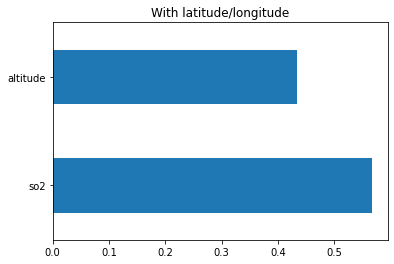

In [ ]:
feat_importances.nlargest(20).plot(kind='barh', title='With latitude/longitude')

In [ ]:
df2_results = pd.DataFrame({"dataset": "Two features: SO2 from satellites and altitude",
                            "relative_error": round(relative_error(y_test, y_test_pred), 2),
                            "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred), 2),
                            "mean_squared_error": round(mean_squared_error(y_test, y_test_pred), 2), 
                            "median_absolute_error": round(median_absolute_error(y_test, y_test_pred), 2),
                            "explained_variance_score": round(explained_variance_score(y_test, y_test_pred),2),
                            "r2_score": round(r2_score(y_test, y_test_pred), 2)}, index=[0])
results_features = pd.concat([results_features, df2_results]).reset_index(drop = True)

In [ ]:
results_features

dataset  relative_error  \
0     One feature: SO2 from satellites (Baseline)           12.53   
1  Two features: SO2 from satellites and altitude            7.01   

   mean_absolute_error  mean_squared_error  median_absolute_error  \
0                 4.45               80.28                   2.28   
1                 3.67               61.90                   1.91   

   explained_variance_score  r2_score  
0                     -0.37     -0.37  
1                     -0.05     -0.05

### 3. Features: SO2 from satellites, altitude & lat/long

In [ ]:
df3=df_basic

In [ ]:
df3.head(2)

longitude  latitude  altitude           so2  so2_target
0    12.0800   54.1713       2.0  8.879602e-07       1.099
1     2.8074   50.3089      90.0  1.016114e-06       0.200

In [ ]:
features = df3.drop('so2',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = scaling_and_splitting(df3)

In [ ]:
model = RandomForestRegressor(random_state = seed)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
feat_importances = pd.Series(
        model.feature_importances_,
        index=features.columns).sort_values(
        ascending=False)
feat_importances

longitude     0.408487
altitude      0.239359
latitude      0.209001
so2_target    0.143153
dtype: float64

In [ ]:
figure = impPlot(feat_importances, "With new features & with lat/long")
figure

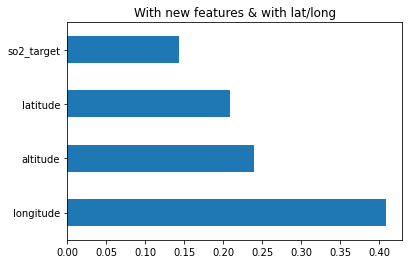

In [ ]:
feat_importances.nlargest(20).plot(kind='barh',title='With new features & with lat/long')

In [ ]:
df3_results = pd.DataFrame({"dataset": "Using features: SO2 from satellites, altitude & lat/long",
                            "relative_error": round(relative_error(y_test, y_test_pred), 2),
                            "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred), 2),
                            "mean_squared_error": round(mean_squared_error(y_test, y_test_pred), 2),
                            "median_absolute_error": round(median_absolute_error(y_test, y_test_pred), 2),
                            "explained_variance_score": round(explained_variance_score(y_test, y_test_pred),2),
                            "r2_score": round(r2_score(y_test, y_test_pred), 2)}, index=[0])
results_features = pd.concat([results_features, df3_results]).reset_index(drop = True)

### 4. Features: SO2 from satellites, altitude, lat/long & new features

In [ ]:
df_adv.head(2)

longitude  latitude  altitude           so2  so2_target          pm10
0    12.0800   54.1713       2.0  8.879602e-07       1.099  1.360516e-08
1     2.8074   50.3089      90.0  1.016114e-06       0.200  1.720592e-08

In [ ]:
X_train, X_test, y_train, y_test = scaling_and_splitting(df_adv)

In [ ]:
features = df_adv.drop('so2_target',axis=1)

In [ ]:
model = RandomForestRegressor(random_state = seed)
model.fit(X_train, y_train)
feat_importances = pd.Series(
        model.feature_importances_,
        index=features.columns).sort_values(
        ascending=False)
feat_importances

longitude    0.379726
latitude     0.192750
altitude     0.182167
pm10         0.129821
so2          0.115537
dtype: float64

In [ ]:
figure = impPlot(feat_importances, "With new features & without lat/long")
figure

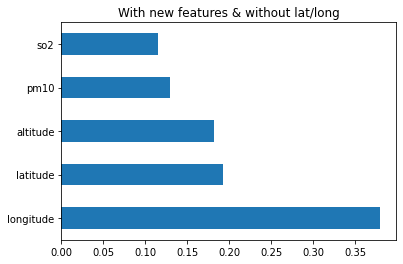

In [ ]:
feat_importances.nlargest(20).plot(kind='barh', title='With new features & without lat/long')

In [ ]:
y_test_pred = model.predict(X_test)
df2_results = pd.DataFrame({"dataset": "With new features & without lat/long",
                            "relative_error": round(relative_error(y_test, y_test_pred), 2),
                            "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred), 2),
                            "mean_squared_error": round(mean_squared_error(y_test, y_test_pred), 2),
                            "median_absolute_error": round(median_absolute_error(y_test, y_test_pred), 2),
                            "explained_variance_score": round(explained_variance_score(y_test, y_test_pred),2),
                            "r2_score": round(r2_score(y_test, y_test_pred), 2)}, index=[0])
results_features = pd.concat([results_features, df2_results]).reset_index(drop = True)

### Summary

In [ ]:
results_features

dataset  relative_error  \
0        One feature: SO2 from satellites (Baseline)           12.53   
1     Two features: SO2 from satellites and altitude            7.01   
2  Using features: SO2 from satellites, altitude ...            7.58   
3               With new features & without lat/long            7.82   

   mean_absolute_error  mean_squared_error  median_absolute_error  \
0                 4.45               80.28                   2.28   
1                 3.67               61.90                   1.91   
2                 2.59               32.56                   1.03   
3                 2.61               30.01                   1.13   

   explained_variance_score  r2_score  
0                     -0.37     -0.37  
1                     -0.05     -0.05  
2                      0.45      0.45  
3                      0.49      0.49

## Training the model with different classifiers

In [ ]:
X_train, X_test, y_train, y_test = scaling_and_splitting(df2)

In [ ]:
results = pd.DataFrame()
results = pd.DataFrame(columns=["classifier","mean_absolute_error", "mean_squared_error", "median_absolute_error", "explained_variance_score", "r2_score"])

### Different classifiers

In [ ]:
# Linear regression
clf_lr = LinearRegression()
clf_lr.fit(X_train, y_train)
y_test_pred = clf_lr.predict(X_test)

In [ ]:
lr_results = pd.DataFrame({"classifier": "LinearRegression",
                           "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred), 2), 
                           "mean_squared_error": round(mean_squared_error(y_test, y_test_pred), 2), 
                           "median_absolute_error": round(median_absolute_error(y_test, y_test_pred), 2), 
                           "explained_variance_score": round(explained_variance_score(y_test, y_test_pred), 2), 
                           "r2_score": round(r2_score(y_test, y_test_pred), 2)}, index=[0])
results = pd.concat([lr_results, results]).reset_index(drop = True)

In [ ]:
# Decision Tree Regressor
clf_dtr = DecisionTreeRegressor()
clf_dtr.fit(X_train, y_train)
y_test_pred_dtr = clf_dtr.predict(X_test)

In [ ]:
dtr_results = pd.DataFrame({"classifier": "DecisionTreeRegression",
                           "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred_dtr), 2), 
                           "mean_squared_error": round(mean_squared_error(y_test, y_test_pred_dtr), 2), 
                           "median_absolute_error": round(median_absolute_error(y_test, y_test_pred_dtr), 2), 
                           "explained_variance_score": round(explained_variance_score(y_test, y_test_pred_dtr), 2), 
                           "r2_score": round(r2_score(y_test, y_test_pred_dtr), 2)}, index=[0])
results = pd.concat([dtr_results, results]).reset_index(drop = True)

In [ ]:
# Support Vector Regression
clf_svr = SVR()
clf_svr.fit(X_train, y_train)
y_test_pred_svr = clf_svr.predict(X_test)


In [ ]:
svr_results = pd.DataFrame({"classifier": "SupportVectorRegression",
                           "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred_svr), 2), 
                           "mean_squared_error": round(mean_squared_error(y_test, y_test_pred_svr), 2), 
                           "median_absolute_error": round(median_absolute_error(y_test, y_test_pred_svr), 2), 
                           "explained_variance_score": round(explained_variance_score(y_test, y_test_pred_svr), 2), 
                           "r2_score": round(r2_score(y_test, y_test_pred_svr), 2)}, index=[0])
results = pd.concat([svr_results, results]).reset_index(drop = True)

In [ ]:
# Random Forest Regressor
clf_rfr = RandomForestRegressor(random_state = seed)
clf_rfr.fit(X_train, y_train)
y_test_pred_rfr = clf_rfr.predict(X_test)

In [ ]:
rfr_results = pd.DataFrame({"classifier": "RandomForestRegression",
                           "mean_absolute_error": round(mean_absolute_error(y_test, y_test_pred_rfr), 2), 
                           "mean_squared_error": round(mean_squared_error(y_test, y_test_pred_rfr), 2), 
                           "median_absolute_error": round(median_absolute_error(y_test, y_test_pred_rfr), 2), 
                           "explained_variance_score": round(explained_variance_score(y_test, y_test_pred_rfr), 2), 
                           "r2_score": round(r2_score(y_test, y_test_pred_rfr), 2)}, index=[0])
results = pd.concat([rfr_results, results]).reset_index(drop = True)

### Summary

In [ ]:
results

classifier  mean_absolute_error  mean_squared_error  \
0   RandomForestRegression                 3.10               44.28   
1  SupportVectorRegression                 3.17               51.18   
2   DecisionTreeRegression                 3.48               59.84   
3         LinearRegression                 3.41               49.82   

   median_absolute_error  explained_variance_score  r2_score  
0                   1.53                      0.25      0.25  
1                   1.48                      0.17      0.13  
2                   1.64                     -0.01     -0.02  
3                   1.99                      0.16      0.15

We are looking forward other classifiers to investigate (LASSO Classifier).

How do we evaluate the classifiers?
The idea is to choose among the above classifiers which one give us the best results according to the metrics we chose to focus on (likely to change).

Hyperparameter tuning - draft

In [ ]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import numpy as np

According to documentation, linear regression is impossible to tune without using the Lasso or Ridge Regression.